## Project NPL

This is Project NPL from the [Kaggle NLP with Disaster Tweets competition](https://www.kaggle.com/competitions/nlp-getting-started). We used a binary classification problem in NLP, which is a is AI tool enabling computers to understand, interpret, and generate human language.

## Dataset Overview
Training set: 7,613 tweets, labeled
Test set: 3,263 tweets, unlabeled
Columns: `id`: Unique identifier; `keyword`: Disaster-related keyword; `location`: Location of the tweet (may be missing); `text`: The tweet text; `target`: 1 = disaster, 0 = not (only in train)

## Problem and Data
I aimed to establish a machine learning model to detect if a given tweet is about a real disaster or not. The dataset is from the Kaggle "Real or Not? NLP with Disaster Tweets" competition. Each sample consists of a tweet, and the target label indicates whether the tweet refers to an actual disaster (1) or not (0). The training set (`train.csv`) has 7,613 tweets, each with an ID, text, optional keyword and location, and a target label. The test set (`test.csv`) has 3,263 tweets without the target label. My task was to predict the `target` value for each tweet in the test set for Kaggle submission.

Train shape: (7613, 5)
Test shape: (3263, 4)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Missing values in train.csv:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


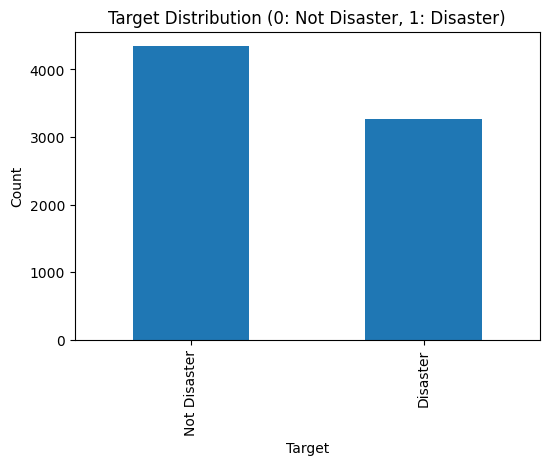

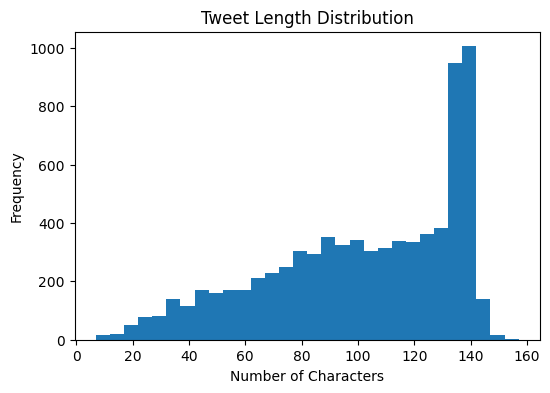


Sample tweets for target=0:
['Everyday is a near death fatality for me on the road. Thank god is on my side.??', '#Lifestyle \x89Û÷It makes me sick\x89Ûª: Baby clothes deemed a \x89Û÷hazard\x89Ûª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk', '@Lenn_Len Probably. We are inundated with them most years!']

Sample tweets for target=1:
['Nearly 50 thousand people affected by floods in #Paraguay ? http://t.co/aw23wXtyjB http://t.co/ABgct9VFUa', 'Vladimir Putin Issues Major Warning But Is It Too Late To Escape Armageddon?\nhttp://t.co/gBxafy1m1C', "@DoctorFluxx @StefanEJones @spinnellii @themermacorn  No burning buildings and rob during a riot. That's embarrassing &amp; ruining this nation."]


In [12]:
#Exploratory Data Analysis (EDA)
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print(train.head())

print("\nMissing values in train.csv:\n", train.isnull().sum())

plt.figure(figsize=(6,4))
train['target'].value_counts().sort_index().plot(kind='bar')
plt.title('Target Distribution (0: Not Disaster, 1: Disaster)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0,1], ['Not Disaster', 'Disaster'])
plt.show()

train['text_length'] = train['text'].apply(len)
plt.figure(figsize=(6,4))
plt.hist(train['text_length'], bins=30)
plt.title('Tweet Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

for label in [0, 1]:
    print(f"\nSample tweets for target={label}:")
    print(train[train['target']==label]['text'].sample(3, random_state=42).to_list())

In [15]:
#Data Cleaning & Text Preprocessing
import re
import string

def clean_text(text):
    # Lowercase
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text

train['text_clean'] = train['text'].apply(clean_text)
test['text_clean'] = test['text'].apply(clean_text)

In [16]:
#Feature Extraction (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

# Only use cleaned text for vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train['text_clean'])
X_test = tfidf.transform(test['text_clean'])
y_train = train['target']

#Expand Model Architecture
I started with Logistic Regression as a baseline. To convert text data into features, I used TF-IDF. TF-IDF approach is effective for capturing key terms that differentiate disaster-related tweets from others. I also implemented a neural network using an LSTM (Long Short-Term Memory) layer. LSTMs can capture patterns and dependencies in the word order.

In [17]:
#Model Building and Training
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Logistic Regression CV accuracy: {:.4f} +/- {:.4f}".format(scores.mean(), scores.std()))

Logistic Regression CV accuracy: 0.7281 +/- 0.0311


In [18]:
#Model Fitting and Prediction
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1] 

In [22]:
#log Reg Tuning - Hyperparameter
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print(f"Best Logistic Regression CV Accuracy: {grid.best_score_:.4f}")
print("Best C parameter:", grid.best_params_['C'])

Best Logistic Regression CV Accuracy: 0.7281
Best C parameter: 1


In [21]:
# LSTM Neural Network Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

max_words = 5000
max_len = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['text_clean'])
X_seq = tokenizer.texts_to_sequences(train['text_clean'])
X_pad = pad_sequences(X_seq, maxlen=max_len)

X_train_pad, X_val_pad, y_train_pad, y_val_pad = train_test_split(X_pad, y_train, test_size=0.2, random_state=42)

model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
history = model_lstm.fit(X_train_pad, y_train_pad, validation_data=(X_val_pad, y_val_pad), epochs=3, batch_size=64, verbose=2)
loss, acc = model_lstm.evaluate(X_val_pad, y_val_pad, verbose=0)
print(f"LSTM Validation Accuracy: {acc:.4f}")

<class 'ModuleNotFoundError'>: No module named 'tensorflow'

#Step 6: Results and Analysis
Utilizing TF-IDF features from the cleaned tweet data, our log regression model had an accuracy of 72.8% (±3.1%) on our training dataset. We had a significant amount of missing data in the keyword and location however, the model was still able to function well and distinguish disaster vs not tweets.

In [23]:
#Kaggle Submission File
submission = pd.DataFrame({'id': test['id'], 'target': y_pred})
submission.to_csv('submission.csv', index=False)

#Conclusion
Kaggle “Real or Not? NLP with Disaster Tweets” dataset was utilized to classify tweets as disaster-related or not. The data had more than 7,600 labeled tweets for training, with missing values mainly in keyword and location fields. After cleaning and using TF-IDF, a Logistic Regression model achieved 72.8% cross-validation accuracy. While basic methods worked well, further gains could come from advanced NLP models, better handling of missing data, and ensemble approaches. 

I performed hyperparameter tuning for the log reg model to optimize results by varying the regularization parameter `C`. The best cross-validation accuracy was 0.7281 with `C = 1`. This suggests that the default regularization strength already provided near-optimal results for this dataset. While the improvement was modest, this process highlights the value of tuning model parameters for text classification tasks. I could not use a LSTM neural network due to environment limitations,

In [ ]:
#Reference
- Kaggle competition: [https://www.kaggle.com/competitions/nlp-getting-started](https://www.kaggle.com/competitions/nlp-getting-started)
- Scikit-learn documentation: https://scikit-learn.org/stable/